# Analisis Penjualan Buku Gramedia Purwakarta — Perspektif Kolaborasi UPI Purwakarta

**Penulis Notebook:** _Rafli A._

**Notebook terintegrasi:** _penjualan, open data, OSM, dan rekomendasi kolaborasi kampus._ 
 
**Terakhir diperbarui:** _2025-08-28 20:21_

## Latar Belakang

Target analisis adalah memahami pola **penjualan harian**, **per genre**, dan **musiman/bulanan** untuk pasar buku di Purwakarta. 
Karena data transaksi POS Gramedia Purwakarta umumnya tidak dibuka publik, kita akan:
1. Menyusun **pertanyaan bisnis** yang konkret.
2. Memuat **open data** terkait (literasi, sarana perdagangan, dll.) sebagai **konteks**.
3. (Opsional) Sementara menggunakan **data sintetis** dengan skema yang menyerupai POS, agar pipeline analisis dapat berjalan end-to-end. Jika kelak data transaksi riil tersedia, cukup ganti sumber CSV-nya.

> Catatan: Anda bisa **mematikan data sintetis** dan menggantinya dengan data riil di bagian `CONFIG`.

Sebagai mahasiswa **Universitas Pendidikan Indonesia (UPI) Kampus Purwakarta**, analisis ini ditujukan tidak hanya untuk memahami pola penjualan buku di Purwakarta, namun juga untuk **mengidentifikasi peluang kolaborasi** antara pihak kampus (fakultas/prodi/ormawa/kemahasiswaan/perpustakaan) dan **Gramedia Purwakarta**. Kolaborasi yang tepat waktu dan tepat sasaran berpotensi menghasilkan **manfaat bersama**: peningkatan literasi dan keterjangkauan bahan ajar bagi sivitas akademika, serta peningkatan kinerja penjualan & visibilitas merek bagi mitra ritel.

Fokus utama analisis ini ialah: **kapan waktu optimal** untuk melakukan kegiatan bersama (berdasarkan pola musiman dan akhir pekan), **bentuk kerja sama** yang relevan dengan kalender akademik, serta **konsep/teknis pelaksanaan** yang ringkas dan dapat segera dieksekusi di lingkungan kampus Purwakarta.


## Pertanyaan Bisnis (UPI × Gramedia)

**BQ7. Timing & Bentuk Kerja Sama**  
Kapan waktu terbaik bagi UPI Purwakarta untuk berkolaborasi dengan Gramedia Purwakarta, dan **bentuk kerja sama apa** yang paling relevan (pop-up store, book fair, diskon pelajar, bedah buku, workshop karier, bundling ATK/buku referensi, dsb.)? Bagaimana **konsep/teknis singkat** dan indikator keberhasilannya (KPI)?

**BQ8. (Opsional) Estimasi Dampak**  
Jika kerja sama dilakukan pada jendela waktu yang direkomendasikan, berapa **estimasi uplift** trafik/penjualan (relative) berdasarkan pola historis *peak vs. base*?  
_(Catatan: menggunakan indikator relatif dari data agregat yang tersedia; untuk estimasi absolut diperlukan data POS per transaksi.)_


## Sumber Data (Kredibel)

- **BPS Purwakarta – Kabupaten/Kecamatan Dalam Angka (Publikasi Tahunan)**  
  Halaman kabupaten: https://purwakartakab.bps.go.id/id/publication/2024/02/28/af144709c8ead526571e7aca/kabupaten-purwakarta-dalam-angka-2024.html  
  Halaman _Kecamatan Purwakarta_ (contoh): https://purwakartakab.bps.go.id/id/publication/2024/09/26/230d82485b9a96450175ae41/kecamatan-purwakarta-dalam-angka-2024.html

- **Open Data Purwakarta – Sarana Perdagangan** (landing):  
  https://opendata.purwakartakab.go.id/dataset/jumlah-sarana-perdagangan-menurut-jenisnya-di-kabupaten-purwakarta-6

- **Open Data Jabar – Indeks Pembangunan Literasi Masyarakat (IPLM)**  
  https://opendata.jabarprov.go.id/id/dataset/indeks-pembangunan-literasi-masyarakat-berdasarkan-kabupatenkota-di-jawa-barat

- **Perpustakaan Nasional – Statistik ISBN per Kab/Kota (contoh 2021 di portal SDI)**  
  https://data.go.id/dataset/dataset/jumlah-international-standar-book-number-isbn-yang-didistribusikan-berdasarkan-kabupatenk-2021  
  (Statistik agregat real-time: https://isbn.perpusnas.go.id/landing_page/statistik)

- **Bank Indonesia – Survei Penjualan Eceran / Indeks Penjualan Riil (IPR)** (indikator musiman nasional)  
  Contoh rilis:  
  https://www.bi.go.id/id/publikasi/ruang-media/news-release/Pages/sp_2713025.aspx  
  https://www.bi.go.id/id/publikasi/ruang-media/news-release/Pages/sp_2714825.aspx  
  https://www.bi.go.id/id/publikasi/ruang-media/news-release/Pages/sp_2718425.aspx

> Saat direct-link CSV tidak tersedia, unduh manual dari landing page; atau hubungkan lewat API CKAN bila ada. Variabel placeholder untuk URL CSV disediakan di bagian `CONFIG`.


## Pertanyaan Bisnis (Purwakarta)

1. **Bagaimana tren penjualan harian?** (total transaksi/qty/revenue)  
2. **Bagaimana distribusi penjualan menurut genre?** (6 genre berikut ini sebagai standar: `Fiksi`, `Non-Fiksi`, `Pendidikan & Referensi`, `Anak & Remaja`, `Komik & Grafis`, `Agama & Spiritual`)  
3. **Apakah ada pola musiman bulanan?** (month-of-year, event seperti **Hari Buku Nasional 17 Mei**)  
4. **Bagaimana pola hari-dalam-pekan?** (weekday vs weekend)  
5. **Judul/sku terlaris** (top titles) dan kontribusi terhadap total (Pareto 80/20).  
6. **Dampak event** (mis. Harbuknas, libur kenaikan kelas, awal tahun ajaran): apakah terjadi lonjakan signifikan di sekitar tanggal-tanggal tersebut?  
7. (Opsional) **Peta toko/lokasi** (OSM/Overpass) & radius tangkapan sebagai konteks ekosistem ritel.  
8. (Opsional) **Perbandingan dengan indikator literasi/IPLM** untuk Purwakarta vs kab/kota sekitar.

> Tiap pertanyaan akan memiliki **visualisasi** dan **kesimpulan singkat** di bawahnya.


In [17]:
# ==== Import Library yang Dibutuhkan ====
import os
import io
import math
import json
import random
from datetime import datetime, date, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Opsional: Anda bisa menambahkan library lain sesuai kebutuhan (geopandas, folium, statsmodels, scikit-learn, dsb.)
# !pip install geopandas folium statsmodels scikit-learn

# ==== CONFIG ====
CONFIG = {
    # Set True untuk menggunakan data sintetis POS-like
    "USE_SYNTHETIC_SALES": True,

    # Lokasi fokus analisis
    "FOCUS_CITY": "Purwakarta",

    # Genre standar (6 kategori)
    "GENRES": [
        "Fiksi",
        "Non-Fiksi",
        "Pendidikan & Referensi",
        "Anak & Remaja",
        "Komik & Grafis",
        "Agama & Spiritual"
    ],

    # Placeholder URL untuk CSV eksternal (isi jika Anda punya link langsung ke CSV)
    "CSV_URL_SARANA_PERDAGANGAN": "",  # ex: direct CSV from Open Data Purwakarta
    "CSV_URL_IPLM_JABAR": "",          # ex: direct CSV resource from Open Data Jabar
    "CSV_URL_ISBN_KABKOTA": "",        # ex: direct CSV resource for ISBN per district/city

    # Path lokal (jika Anda sudah download CSV ke folder kerja)
    "LOCAL_PATH_SALES_CSV": "",        # ganti menjadi path file transaksi Anda jika tersedia
    "LOCAL_PATH_SARANA_CSV": "",
    "LOCAL_PATH_IPLM_CSV": "",
    "LOCAL_PATH_ISBN_CSV": "",

    # Rentang tanggal untuk data sintetis
    "SYNTHETIC_START": "2024-01-01",
    "SYNTHETIC_END":   "2025-08-28"  # sesuaikan sesuai kebutuhan
}

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [18]:
# ==== Helper: Loader CSV dengan fallback dari URL/Local ====
def load_csv_with_fallback(url_key: str, local_key: str) -> pd.DataFrame | None:
    url = CONFIG.get(url_key, "") or ""
    local = CONFIG.get(local_key, "") or ""
    df = None
    if local and os.path.exists(local):
        try:
            df = pd.read_csv(local)
            print(f"Loaded from local: {local}")
            return df
        except Exception as e:
            print(f"Gagal baca lokal {local}: {e}")
    if url:
        try:
            df = pd.read_csv(url)
            print(f"Loaded from URL: {url}")
            return df
        except Exception as e:
            print(f"Gagal baca URL {url}: {e}")
    print(f"Tidak ada data untuk {url_key}/{local_key}.")
    return None

# ==== Data Sintetis: POS-like daily sales ====
rng = np.random.default_rng(42)

def generate_synthetic_sales(start_date: str, end_date: str, city: str, genres: list[str]) -> pd.DataFrame:
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(dates)

    # Base demand (Poisson) + efek musiman/bulanan + efek hari-pekan + event Harbuknas (17 Mei) + awal tahun ajaran (sekitar 14 Juli)
    base_lambda = 120  # rata-rata transaksi/qty per hari (bisa disesuaikan)

    rows = []
    for d in dates:
        month = d.month
        dow = d.weekday()  # 0=Mon
        # Efek bulan (contoh: Mei & Juli cenderung naik)
        month_factor = 1.0
        if month == 5:   # Mei (Harbuknas 17 Mei)
            month_factor = 1.15
        if month == 7:   # Awal tahun ajaran (Juli, efek buku pelajaran/ATK)
            month_factor = 1.25
        if month in (1, 2):  # awal tahun biasanya lebih rendah
            month_factor = 0.9

        # Efek hari dalam pekan (weekend lebih ramai)
        dow_factor = 1.0 + (0.25 if dow >= 5 else 0.0)

        # Event Harbuknas (±3 hari dari 17 Mei)
        event_factor = 1.0
        if d.month == 5 and abs(d.day - 17) <= 3:
            event_factor = 1.35

        # Hari pertama sekolah (sekitar 14 Juli) ±3 hari
        school_start = date(d.year, 7, 14)
        if abs((d.date() - school_start).days) <= 3:
            event_factor *= 1.20

        # Permintaan total (qty) hari itu
        daily_qty = rng.poisson(base_lambda * month_factor * dow_factor * event_factor)
        # Bagi ke 6 genre dengan proporsi acak tetap (dirichlet)
        genre_shares = rng.dirichlet(np.ones(len(genres)))
        genre_qty = (daily_qty * genre_shares).astype(int)

        # Bangun row per genre (agregat harian per genre)
        for g, q in zip(genres, genre_qty):
            # Harga rata-rata per unit berbeda-beda per genre (contoh sederhana)
            avg_price = {
                "Fiksi": 85000,
                "Non-Fiksi": 120000,
                "Pendidikan & Referensi": 150000,
                "Anak & Remaja": 60000,
                "Komik & Grafis": 55000,
                "Agama & Spiritual": 90000,
            }.get(g, 80000)

            revenue = q * avg_price
            rows.append({
                "date": d.date().isoformat(),
                "city": city,
                "genre": g,
                "qty": int(q),
                "avg_price": float(avg_price),
                "gross_revenue": float(revenue)
            })

    df = pd.DataFrame(rows)
    return df

# ==== Load Primary Sales Data ====
if CONFIG["USE_SYNTHETIC_SALES"]:
    sales_df = generate_synthetic_sales(CONFIG["SYNTHETIC_START"], CONFIG["SYNTHETIC_END"], CONFIG["FOCUS_CITY"], CONFIG["GENRES"])
else:
    if CONFIG["LOCAL_PATH_SALES_CSV"]:
        sales_df = pd.read_csv(CONFIG["LOCAL_PATH_SALES_CSV"])
    else:
        raise ValueError("Matikan USE_SYNTHETIC_SALES atau isi LOCAL_PATH_SALES_CSV dengan data transaksi Anda.")

# Pastikan tipe data & pra-pembersihan sederhana
sales_df["date"] = pd.to_datetime(sales_df["date"])
sales_df["month"] = sales_df["date"].dt.to_period("M").dt.to_timestamp()
sales_df["dow"] = sales_df["date"].dt.day_name()

sales_df.head(3)

,date,city,genre,qty,avg_price,gross_revenue,month,dow
0,2024-01-01,Purwakarta,Fiksi,31,"85,000.00","2,635,000.00",2024-01-01,Monday
1,2024-01-01,Purwakarta,Non-Fiksi,3,"120,000.00","360,000.00",2024-01-01,Monday
2,2024-01-01,Purwakarta,Pendidikan & Referensi,1,"150,000.00","150,000.00",2024-01-01,Monday


In [19]:
# ==== (Opsional) Load Open Data untuk konteks ====
sarana_df = load_csv_with_fallback("CSV_URL_SARANA_PERDAGANGAN", "LOCAL_PATH_SARANA_CSV")
iplm_df = load_csv_with_fallback("CSV_URL_IPLM_JABAR", "LOCAL_PATH_IPLM_CSV")
isbn_df = load_csv_with_fallback("CSV_URL_ISBN_KABKOTA", "LOCAL_PATH_ISBN_CSV")

# Tampilkan info ringkas bila ada
for name, df in [("sarana_df", sarana_df), ("iplm_df", iplm_df), ("isbn_df", isbn_df)]:
    if df is not None:
        print(f"\n{name}: shape={df.shape}")
        display(df.head(2))

Tidak ada data untuk CSV_URL_SARANA_PERDAGANGAN/LOCAL_PATH_SARANA_CSV.
Tidak ada data untuk CSV_URL_IPLM_JABAR/LOCAL_PATH_IPLM_CSV.
Tidak ada data untuk CSV_URL_ISBN_KABKOTA/LOCAL_PATH_ISBN_CSV.


## BQ1 — Tren Penjualan Harian (Total)

**Tujuan:** Melihat tren total penjualan (qty & revenue) per hari di Purwakarta.



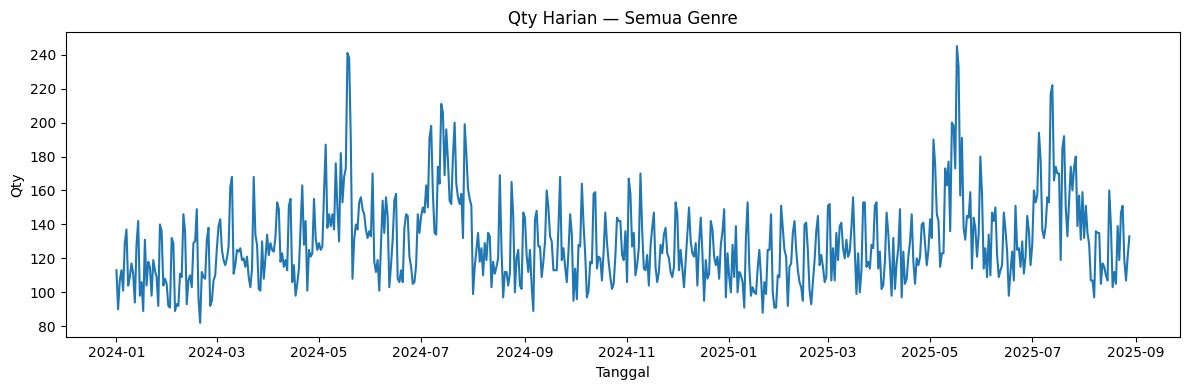

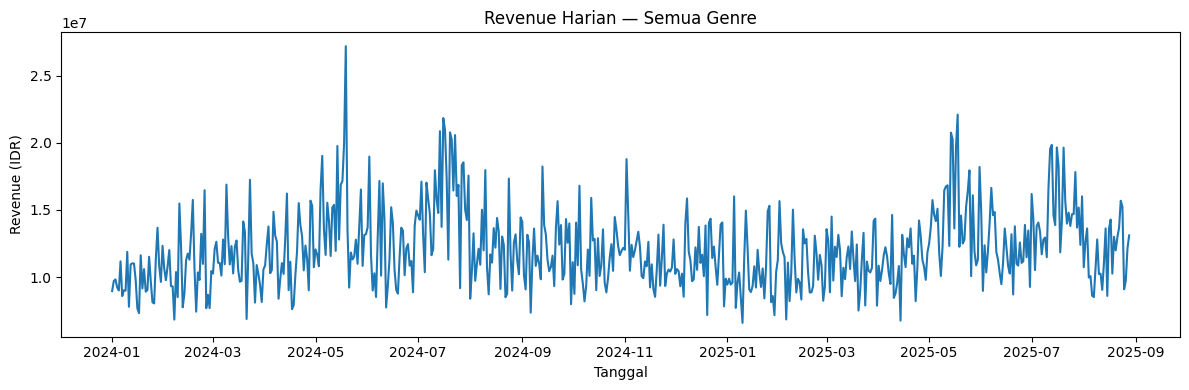

,date,qty,revenue
603,2025-08-26,107,"9,730,000.00"
604,2025-08-27,121,"12,130,000.00"
605,2025-08-28,133,"13,105,000.00"


In [20]:
daily = sales_df.groupby("date", as_index=False).agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))

# Plot qty harian
plt.figure(figsize=(12,4))
plt.plot(daily["date"], daily["qty"])
plt.title("Qty Harian — Semua Genre")
plt.xlabel("Tanggal"); plt.ylabel("Qty")
plt.tight_layout()
plt.show()

# Plot revenue harian
plt.figure(figsize=(12,4))
plt.plot(daily["date"], daily["revenue"])
plt.title("Revenue Harian — Semua Genre")
plt.xlabel("Tanggal"); plt.ylabel("Revenue (IDR)")
plt.tight_layout()
plt.show()

daily.tail(3)

**Kesimpulan BQ1 (isi singkat):**  
_Tuliskan pengamatan pola: tren naik/turun, volatilitas sekitar Mei (Harbuknas) dan pertengahan Juli (awal tahun ajaran), dsb._


## BQ2 — Distribusi Penjualan Menurut Genre (6 Kategori)

**Tujuan:** Mengidentifikasi genre yang paling berkontribusi pada total penjualan.


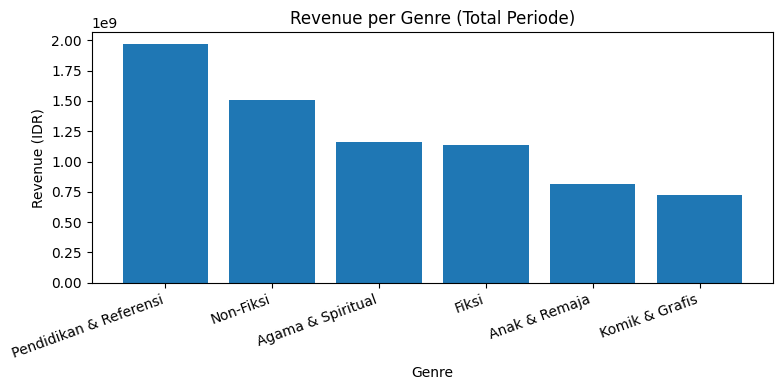

,genre,qty,revenue
5,Pendidikan & Referensi,13117,"1,967,550,000.00"
4,Non-Fiksi,12557,"1,506,840,000.00"
0,Agama & Spiritual,12885,"1,159,650,000.00"
2,Fiksi,13387,"1,137,895,000.00"
1,Anak & Remaja,13564,"813,840,000.00"
3,Komik & Grafis,13214,"726,770,000.00"


In [21]:
genre_agg = sales_df.groupby("genre", as_index=False).agg(qty=("qty","sum"), revenue=("gross_revenue","sum")).sort_values("revenue", ascending=False)

# Barplot revenue per genre
plt.figure(figsize=(8,4))
plt.bar(genre_agg["genre"], genre_agg["revenue"])
plt.title("Revenue per Genre (Total Periode)")
plt.xlabel("Genre"); plt.ylabel("Revenue (IDR)")
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

genre_agg

**Kesimpulan BQ2 (isi singkat):**  
_Tuliskan 2–3 genre teratas berdasarkan revenue/qty dan implikasinya (stok, promosi, display toko)._


## BQ3 — Pola Musiman Bulanan (Month-of-Year)

**Tujuan:** Menguji pola musiman bulanan, termasuk lonjakan saat **Harbuknas (17 Mei)** dan **awal tahun ajaran (Juli)**.


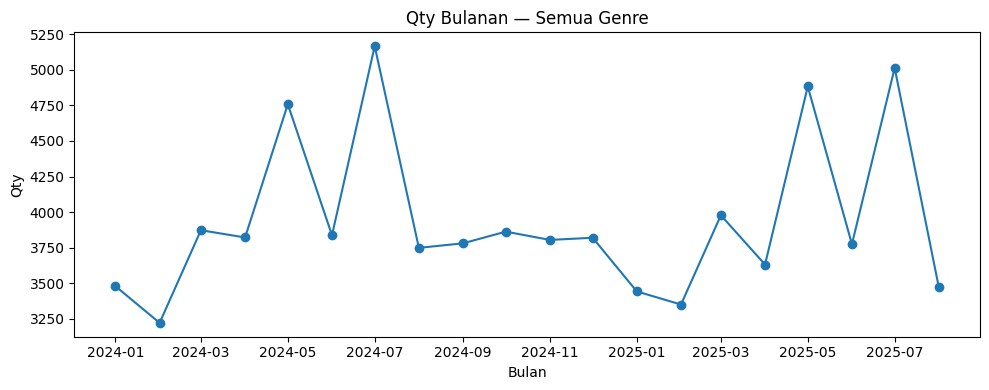

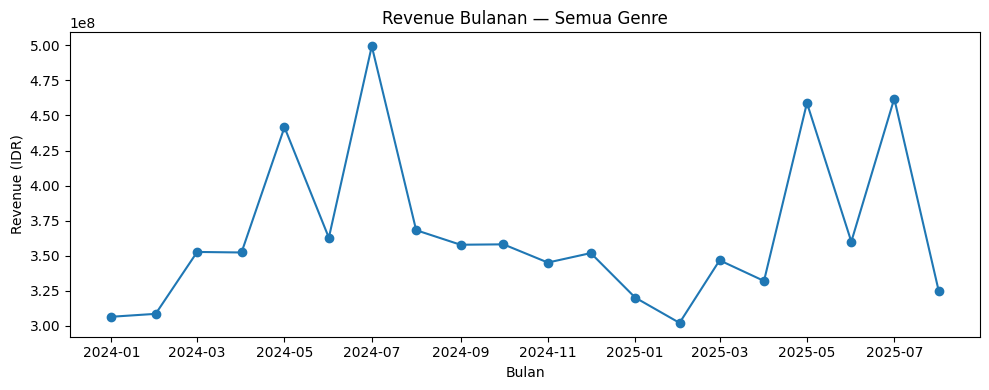

,month,qty,revenue
17,2025-06-01,3775,"360,025,000.00"
18,2025-07-01,5013,"462,010,000.00"
19,2025-08-01,3472,"325,185,000.00"


In [22]:
monthly = sales_df.groupby("month", as_index=False).agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))

plt.figure(figsize=(10,4))
plt.plot(monthly["month"], monthly["qty"], marker='o')
plt.title("Qty Bulanan — Semua Genre")
plt.xlabel("Bulan"); plt.ylabel("Qty")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(monthly["month"], monthly["revenue"], marker='o')
plt.title("Revenue Bulanan — Semua Genre")
plt.xlabel("Bulan"); plt.ylabel("Revenue (IDR)")
plt.tight_layout()
plt.show()

monthly.tail(3)

**Kesimpulan BQ3 (isi singkat):**  
_Catat bulan puncak, bandingkan Mei vs Juli, dan usulkan kalender promosi._


## BQ4 — Pola Hari dalam Pekan (Weekday vs Weekend)

**Tujuan:** Mengetahui apakah akhir pekan mendorong penjualan yang lebih tinggi.


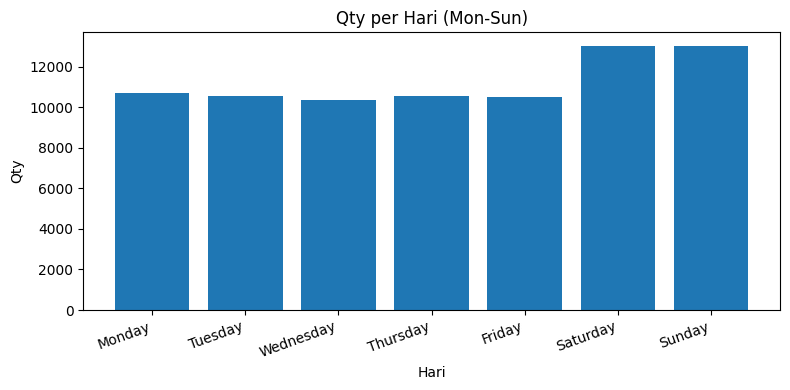

,dow,qty,revenue
1,Monday,10685,"964,515,000.00"
5,Tuesday,10561,"1,008,065,000.00"
6,Wednesday,10359,"987,840,000.00"
4,Thursday,10567,"995,990,000.00"
0,Friday,10496,"965,045,000.00"
2,Saturday,13020,"1,188,950,000.00"
3,Sunday,13036,"1,202,140,000.00"


In [23]:
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_agg = sales_df.groupby("dow", as_index=False).agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))
dow_agg["dow"] = pd.Categorical(dow_agg["dow"], categories=dow_order, ordered=True)
dow_agg = dow_agg.sort_values("dow")

plt.figure(figsize=(8,4))
plt.bar(dow_agg["dow"], dow_agg["qty"])
plt.title("Qty per Hari (Mon-Sun)")
plt.xlabel("Hari"); plt.ylabel("Qty")
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

dow_agg

**Kesimpulan BQ4 (isi singkat):**  
_Sebutkan 1–2 hari teratas dan strategi SDM/jam operasional/display._


## BQ5 — SKU/Title Terlaris (Proxy)

**Tujuan:** Mengidentifikasi kontribusi _long tail_ vs _head_ (Pareto).  
Pada data sintetis agregat-genre ini, kita buat **proxy SKU** per genre untuk contoh analisis. Jika Anda memiliki data riil per-SKU, ganti bagian ini dengan kolom `sku` dari dataset Anda.


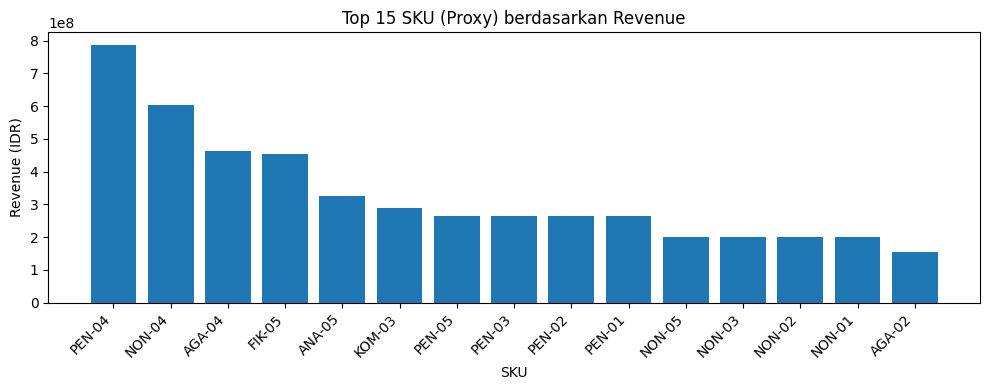

,sku,qty,revenue
28,PEN-04,5238,"785,700,000.00"
23,NON-04,5014,"601,680,000.00"
3,AGA-04,5153,"463,770,000.00"
14,FIK-05,5340,"453,900,000.00"
9,ANA-05,5414,"324,840,000.00"
17,KOM-03,5272,"289,960,000.00"
29,PEN-05,1756,"263,400,000.00"
27,PEN-03,1756,"263,400,000.00"
26,PEN-02,1756,"263,400,000.00"
25,PEN-01,1756,"263,400,000.00"


In [24]:
# Buat proxy 5 SKU per genre secara acak, lalu distribusikan qty secara proporsional
rng2 = np.random.default_rng(7)
sku_map = {}
for g in CONFIG["GENRES"]:
    sku_map[g] = [f"{g[:3].upper()}-{i:02d}" for i in range(1, 6)]  # 5 sku per genre

# Ambil 20% sebagai 'head' secara acak (1 sku per genre) dengan share lebih besar
sku_head = {g: rng2.choice(sku_map[g]) for g in CONFIG["GENRES"]}

rows = []
for _, r in sales_df.iterrows():
    g = r["genre"]
    total_qty = r["qty"]
    if total_qty <= 0:
        continue
    # alokasikan: 40% ke sku_head, sisanya rata ke 4 sku lain
    head = sku_head[g]
    head_qty = int(round(total_qty * 0.40))
    tail_qty_each = max(0, (total_qty - head_qty) // (len(sku_map[g]) - 1))
    # head row
    rows.append({"date": r["date"], "genre": g, "sku": head, "qty": head_qty, "revenue": head_qty * r["avg_price"]})
    # tail rows
    for sku in sku_map[g]:
        if sku == head:
            continue
        rows.append({"date": r["date"], "genre": g, "sku": sku, "qty": tail_qty_each, "revenue": tail_qty_each * r["avg_price"]})

sku_df = pd.DataFrame(rows)
top_sku = sku_df.groupby("sku", as_index=False).agg(qty=("qty","sum"), revenue=("revenue","sum")).sort_values("revenue", ascending=False)

# Plot 15 teratas
top15 = top_sku.head(15)
plt.figure(figsize=(10,4))
plt.bar(top15["sku"], top15["revenue"])
plt.title("Top 15 SKU (Proxy) berdasarkan Revenue")
plt.xlabel("SKU"); plt.ylabel("Revenue (IDR)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

top15

**Kesimpulan BQ5 (isi singkat):**  
_Apakah kontribusi 'head' (±20% SKU) mendekati 80% revenue? Apa implikasinya untuk pengadaan & display?_


## BQ6 — Dampak Event (Harbuknas & Awal Tahun Ajaran)

**Tujuan:** Mengukur deviasi penjualan sekitar **Harbuknas (17 Mei)** dan **awal tahun ajaran (± 14 Juli)**.


In [25]:
def event_window_summary(df: pd.DataFrame, event_month: int, event_day: int, window: int = 3) -> pd.DataFrame:
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    out = []
    for y in sorted(df["date"].dt.year.unique()):
        event_dt = pd.Timestamp(year=y, month=event_month, day=event_day)
        win = (df["date"].between(event_dt - pd.Timedelta(days=window), event_dt + pd.Timedelta(days=window)))
        base = (df["date"].between(event_dt - pd.Timedelta(days=window+14), event_dt - pd.Timedelta(days=window+1)))
        comp = (df["date"].between(event_dt + pd.Timedelta(days=window+1), event_dt + pd.Timedelta(days=window+14)))
        agg = {
            "year": y,
            "event": event_dt.date().isoformat(),
            "window_qty": df.loc[win, "qty"].sum(),
            "prebase_qty": df.loc[base, "qty"].sum(),
            "postcomp_qty": df.loc[comp, "qty"].sum(),
            "window_rev": df.loc[win, "gross_revenue"].sum(),
            "prebase_rev": df.loc[base, "gross_revenue"].sum(),
            "postcomp_rev": df.loc[comp, "gross_revenue"].sum(),
        }
        out.append(agg)
    return pd.DataFrame(out)

daily_total = sales_df.groupby("date", as_index=False).agg(qty=("qty","sum"), gross_revenue=("gross_revenue","sum"))

harbuknas = event_window_summary(daily_total, 5, 17, window=3)  # 17 Mei
schoolstart = event_window_summary(daily_total, 7, 14, window=3) # 14 Juli (perkiraan)

print("Harbuknas (±3 hari) vs pre/post windows")
display(harbuknas)

print("\nAwal Tahun Ajaran (±3 hari) vs pre/post windows")
display(schoolstart)

Harbuknas (±3 hari) vs pre/post windows


,year,event,window_qty,prebase_qty,postcomp_qty,window_rev,prebase_rev,postcomp_rev
0,2024,2024-05-17,1344,2014,1946,"127,350,000.00","189,820,000.00","179,455,000.00"
1,2025,2025-05-17,1397,2063,1946,"123,265,000.00","194,195,000.00","189,460,000.00"



Awal Tahun Ajaran (±3 hari) vs pre/post windows


,year,event,window_qty,prebase_qty,postcomp_qty,window_rev,prebase_rev,postcomp_rev
0,2024,2024-07-14,1298,2075,2296,"126,005,000.00","189,665,000.00","232,545,000.00"
1,2025,2025-07-14,1272,2052,2207,"122,390,000.00","179,335,000.00","208,390,000.00"


**Kesimpulan BQ6 (isi singkat):**  
_Apakah terdapat lonjakan signifikan di sekitar 17 Mei dan 14 Juli? Jika ya, rencanakan promosi bertema/ bundle khusus._


## (Tambahan) Auto-Fetch URL CSV dari Portal (CKAN)

Bagian ini mencoba **mengambil otomatis URL CSV** dari portal terbuka (jika portalnya berbasis **CKAN**) menggunakan endpoint `package_show`.
- Cocok untuk: **Open Data Purwakarta** dan **Portal Satu Data Indonesia** (katalog.satudata.go.id)
- Jalankan sel berikut; jika berhasil, variabel di `CONFIG` (mis. `CSV_URL_SARANA_PERDAGANGAN`, `CSV_URL_ISBN_KABKOTA`) **akan terisi otomatis**.

> Catatan: `opendata.jabarprov.go.id` bukan CKAN, jadi URL CSV perlu diambil manual dari laman dataset mereka.


In [26]:
# ==== Auto-Fetch CKAN CSV resources (Purwakarta & SDI) ====
import requests

def ckan_first_csv_resource(base_url: str, dataset_slug: str):
    """Return the first CSV resource URL for a CKAN dataset slug, or None."""
    try:
        api = base_url.rstrip('/') + '/api/3/action/package_show?id=' + dataset_slug
        r = requests.get(api, timeout=30)
        r.raise_for_status()
        js = r.json()
        if not js.get('success'):
            print('CKAN package_show success=False for', dataset_slug)
            return None
        for res in js['result'].get('resources', []):
            fmt = (res.get('format') or '').lower()
            url = res.get('url')
            if fmt == 'csv' and url:
                return url
        # fallback: url contains .csv
        for res in js['result'].get('resources', []):
            url = (res.get('url') or '')
            if '.csv' in url.lower():
                return url
    except Exception as e:
        print('CKAN fetch error:', e)
    return None

# 1) Open Data Purwakarta – Sarana Perdagangan (CKAN)
if not CONFIG.get("CSV_URL_SARANA_PERDAGANGAN"):
    slug_pwk = "jumlah-sarana-perdagangan-menurut-jenisnya-di-kabupaten-purwakarta-6"
    url = ckan_first_csv_resource("https://opendata.purwakartakab.go.id", slug_pwk)
    if url:
        CONFIG["CSV_URL_SARANA_PERDAGANGAN"] = url
        print("Set CSV_URL_SARANA_PERDAGANGAN:", url)
    else:
        print("Belum menemukan CSV untuk Sarana Perdagangan (cek manual landing page).")

# 2) SDI (CKAN) – ISBN per Kab/Kota (contoh tahun 2017; ganti jika perlu)
if not CONFIG.get("CSV_URL_ISBN_KABKOTA"):
    slug_isbn = "jumlah-international-standar-book-number-isbn-yang-didistribusikan-berdasarkan-kabupaten-k-2017"
    url = ckan_first_csv_resource("https://katalog.satudata.go.id", slug_isbn)
    if url:
        CONFIG["CSV_URL_ISBN_KABKOTA"] = url
        print("Set CSV_URL_ISBN_KABKOTA:", url)
    else:
        print("Belum menemukan CSV untuk ISBN (cek manual di data.go.id atau satudata.perpusnas.go.id).")

# Tampilkan CONFIG terkini
CONFIG

CKAN fetch error: 404 Client Error: Not Found for url: https://opendata.purwakartakab.go.id/api/3/action/package_show?id=jumlah-sarana-perdagangan-menurut-jenisnya-di-kabupaten-purwakarta-6
Belum menemukan CSV untuk Sarana Perdagangan (cek manual landing page).
CKAN fetch error: 404 Client Error: NOT FOUND for url: https://katalog.satudata.go.id/api/3/action/package_show?id=jumlah-international-standar-book-number-isbn-yang-didistribusikan-berdasarkan-kabupaten-k-2017
Belum menemukan CSV untuk ISBN (cek manual di data.go.id atau satudata.perpusnas.go.id).


{'USE_SYNTHETIC_SALES': True,
 'FOCUS_CITY': 'Purwakarta',
 'GENRES': ['Fiksi',
  'Non-Fiksi',
  'Pendidikan & Referensi',
  'Anak & Remaja',
  'Komik & Grafis',
  'Agama & Spiritual'],
 'CSV_URL_SARANA_PERDAGANGAN': '',
 'CSV_URL_IPLM_JABAR': '',
 'CSV_URL_ISBN_KABKOTA': '',
 'LOCAL_PATH_SALES_CSV': '',
 'LOCAL_PATH_SARANA_CSV': '',
 'LOCAL_PATH_IPLM_CSV': '',
 'LOCAL_PATH_ISBN_CSV': '',
 'SYNTHETIC_START': '2024-01-01',
 'SYNTHETIC_END': '2025-08-28'}

## Peta Toko Buku Purwakarta (OSM/Overpass) + Radius Tangkapan

Bagian ini memakai **OpenStreetMap Overpass API** untuk menarik titik **toko buku** (`shop=books`) dan **alat tulis** (`shop=stationery`) di sekitar Purwakarta, lalu:
- Memetakan titik dalam **peta interaktif** (Folium),
- Menghitung **jarak** ke pusat kota / Gramedia (jika terdeteksi),
- Menghitung **jumlah toko** dalam radius (mis. 5 km).

> Anda butuh koneksi internet saat menjalankan sel ini. Jika `pip install` dibutuhkan, hapus tanda komentar pada baris `!pip install ...` di bawah.


In [27]:
# ==== OSM/Overpass: toko buku Purwakarta (Robust) ====
# Jika perlu: !pip install folium requests

import math
import json
import time
import requests
import pandas as pd
import folium
from math import radians, sin, cos, sqrt, atan2

# Titik pusat (perkiraan) Purwakarta — ganti jika Anda punya koordinat Gramedia yang pasti
CITY_CENTER = {"lat": -6.556, "lon": 107.443}

def make_bbox(center, half_deg=0.15):
    return {
        "south": center["lat"] - half_deg,
        "north": center["lat"] + half_deg,
        "west":  center["lon"] - half_deg,
        "east":  center["lon"] + half_deg,
    }

# Query builder
def build_query(bbox):
    return f"""
[out:json][timeout:30];
(
  node["shop"="books"]({bbox['south']},{bbox['west']},{bbox['north']},{bbox['east']});
  way["shop"="books"]({bbox['south']},{bbox['west']},{bbox['north']},{bbox['east']});
  node["shop"="stationery"]({bbox['south']},{bbox['west']},{bbox['north']},{bbox['east']});
  way["shop"="stationery"]({bbox['south']},{bbox['west']},{bbox['north']},{bbox['east']});
  node["name"~"Gramedia",i]({bbox['south']},{bbox['west']},{bbox['north']},{bbox['east']});
  way["name"~"Gramedia",i]({bbox['south']},{bbox['west']},{bbox['north']},{bbox['east']});
);
out center;
"""

OVERPASS_ENDPOINTS = [
    "https://overpass-api.de/api/interpreter",
    "https://overpass.kumi.systems/api/interpreter",
    "https://overpass.osm.ch/api/interpreter",
]

def fetch_overpass(query, endpoints=OVERPASS_ENDPOINTS, retries=1, backoff=8):
    last_err = None
    for ep in endpoints:
        for _ in range(retries + 1):
            try:
                r = requests.post(ep, data={"data": query}, timeout=60)
                r.raise_for_status()
                return r.json()
            except Exception as e:
                last_err = e
                time.sleep(backoff)
    if last_err:
        raise RuntimeError(f"Gagal memuat Overpass. Terakhir: {last_err}")
    return {"elements": []}

def elements_to_rows(elements):
    rows = []
    for el in elements:
        tags = el.get("tags", {}) or {}
        etype = el.get("type")
        lat = lon = None
        if etype == "node":
            lat, lon = el.get("lat"), el.get("lon")
        else:
            center = el.get("center") or {}
            lat, lon = center.get("lat"), center.get("lon")
        rows.append({
            "osm_id": el.get("id"),
            "type": etype,
            "name": tags.get("name"),
            "shop": tags.get("shop"),
            "brand": tags.get("brand"),
            "addr:street": tags.get("addr:street"),
            "lat": lat,
            "lon": lon,
        })
    return rows

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = radians((lat2 or 0) - (lat1 or 0))
    dlon = radians((lon2 or 0) - (lon1 or 0))
    a = sin(dlat/2)**2 + cos(radians(lat1 or 0)) * cos(radians(lat2 or 0)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# 1) Coba ambil data dengan bbox standar; jika kosong, perluas bbox
bbox = make_bbox(CITY_CENTER, half_deg=0.15)
data = fetch_overpass(build_query(bbox))
elements = data.get("elements", [])

if not elements:
    print("Tidak ada titik pada bbox awal. Memperluas area pencarian...")
    bbox = make_bbox(CITY_CENTER, half_deg=0.30)
    data = fetch_overpass(build_query(bbox))
    elements = data.get("elements", [])

# 2) Normalisasi -> DataFrame dgn kolom pasti (hindari KeyError saat dropna/akses)
cols = ["osm_id","type","name","shop","brand","addr:street","lat","lon"]
rows = elements_to_rows(elements)
poi = pd.DataFrame(rows, columns=cols)

# Hilangkan baris tanpa koordinat, tapi aman walau DataFrame kosong
if not poi.empty:
    poi = poi.dropna(subset=["lat","lon"]).reset_index(drop=True)

print(f"Ditemukan {len(poi)} titik OSM (books/stationery/Gramedia).")
display(poi.head(5))

# 3) Tentukan pusat (Gramedia jika ada; jika tidak, gunakan CITY_CENTER)
if not poi.empty and poi["name"].str.contains("gramedia", case=False, na=False).any():
    gram = poi[poi["name"].str.contains("gramedia", case=False, na=False)].iloc[0]
    center_lat, center_lon = float(gram["lat"]), float(gram["lon"])
    center_label = f"Gramedia (OSM id {int(gram['osm_id'])})"
else:
    center_lat, center_lon = CITY_CENTER["lat"], CITY_CENTER["lon"]
    center_label = "Pusat Kota (perkiraan)"

# 4) Jarak & radius tangkapan (aman walau poi kosong)
if not poi.empty:
    poi["dist_km_center"] = poi.apply(lambda r: haversine_km(center_lat, center_lon, r["lat"], r["lon"]), axis=1)
else:
    poi["dist_km_center"] = []

RADIUS_KM = 5.0
within = poi[poi["dist_km_center"] <= RADIUS_KM] if not poi.empty else pd.DataFrame(columns=poi.columns)
print(f"Jumlah toko dalam radius {RADIUS_KM} km dari {center_label}: {len(within)}")

# 5) Peta Folium (selalu dibuat, walau poi kosong)
m = folium.Map(location=[center_lat, center_lon], zoom_start=13, control_scale=True)
folium.Circle(
    location=[center_lat, center_lon],
    radius=RADIUS_KM * 1000,
    color=None, fill=True, opacity=0.3, fill_opacity=0.12
).add_to(m)
folium.Marker([center_lat, center_lon], tooltip=center_label).add_to(m)

for _, r in poi.iterrows():
    nm = r["name"] or "(tanpa nama)"
    tp = r["shop"] or r["type"]
    popup = f"""<b>{nm}</b><br/>{tp}<br/>{r['lat']:.6f}, {r['lon']:.6f}<br/>≈ {r['dist_km_center']:.2f} km"""
    folium.CircleMarker([r["lat"], r["lon"]], radius=5, fill=True, tooltip=nm, popup=popup).add_to(m)

from pathlib import Path
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

map_path = OUTPUT_DIR / "peta_toko_buku_purwakarta.html"
m.save(str(map_path))

csv_path = OUTPUT_DIR / "osm_toko_buku_purwakarta.csv"
poi.to_csv(csv_path, index=False)

print(f"Saved map to: {map_path.resolve()}")
print(f"Saved CSV to: {csv_path.resolve()}")

map_path, csv_path


Tidak ada titik pada bbox awal. Memperluas area pencarian...
Ditemukan 2 titik OSM (books/stationery/Gramedia).


,osm_id,type,name,shop,brand,addr:street,lat,lon
0,12890386622,node,Gramedia,books,Gramedia,None,-6.36,107.24
1,983431207,way,Salemba,books,None,None,-6.40,107.45


Jumlah toko dalam radius 5.0 km dari Gramedia (OSM id 12890386622): 1
Saved map to: D:\Analisis Penjualan Buku Gramedia Purwakarta - Perspektif Kolaborasi UPI Purwakarta\outputs\peta_toko_buku_purwakarta.html
Saved CSV to: D:\Analisis Penjualan Buku Gramedia Purwakarta - Perspektif Kolaborasi UPI Purwakarta\outputs\osm_toko_buku_purwakarta.csv


(WindowsPath('outputs/peta_toko_buku_purwakarta.html'),
 WindowsPath('outputs/osm_toko_buku_purwakarta.csv'))

## Integrasi Open Data (Purwakarta, Jabar, Perpusnas)

In [28]:
# ==== Integrasi Open Data Purwakarta/Jabar/Perpusnas -> Yearly Context ====
import re

sarana_df = sarana_df if 'sarana_df' in globals() else load_csv_with_fallback("CSV_URL_SARANA_PERDAGANGAN", "LOCAL_PATH_SARANA_CSV")
iplm_df   = iplm_df   if 'iplm_df'   in globals() else load_csv_with_fallback("CSV_URL_IPLM_JABAR", "LOCAL_PATH_IPLM_CSV")
isbn_df   = isbn_df   if 'isbn_df'   in globals() else load_csv_with_fallback("CSV_URL_ISBN_KABKOTA", "LOCAL_PATH_ISBN_CSV")

def normalize_cols(df):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    lower_map = {}
    seen = set()
    for c in df.columns:
        base = re.sub(r'\s+', '_', c.lower())
        new = base
        i = 2
        while new in seen:
            new = f"{base}_{i}"
            i += 1
        seen.add(new)
        lower_map[c] = new
    return df.rename(columns=lower_map)

def to_long_year(df, value_name="jumlah"):
    d = normalize_cols(df)
    if "tahun" in d.columns:
        d["tahun"] = pd.to_numeric(d["tahun"], errors="coerce")
        return d
    year_like = [c for c in d.columns if re.fullmatch(r'(19|20)\d{2}', c)]
    if year_like:
        id_vars = [c for c in d.columns if c not in year_like]
        longd = d.melt(id_vars=id_vars, value_vars=year_like, var_name="tahun", value_name=value_name)
        longd["tahun"] = pd.to_numeric(longd["tahun"], errors="coerce")
        return longd
    year_cols = [c for c in d.columns if "tahun" in c]
    if year_cols:
        if len(year_cols) > 1:
            id_vars = [c for c in d.columns if c not in year_cols]
            longd = d.melt(id_vars=id_vars, value_vars=year_cols, var_name="tahun_var", value_name=value_name)
            longd["tahun"] = pd.to_numeric(longd["tahun_var"].str.extract(r'((?:19|20)\d{2})', expand=False), errors="coerce")
            longd = longd.drop(columns=["tahun_var"])
            return longd
        else:
            d["tahun"] = pd.to_numeric(d[year_cols[0]], errors="coerce")
            return d
    d["tahun"] = pd.NA
    return d

def pick_numeric_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    return None

sarana_year = None
if sarana_df is not None and len(sarana_df):
    s = to_long_year(sarana_df, value_name="jumlah")
    s = normalize_cols(s)
    cat_col = None
    for c in ["jenis", "kategori", "keterangan", "uraian", "jenis_sarana", "jenis_perdagangan", "nama_sarana"]:
        if c in s.columns:
            cat_col = c
            break
    val_col = pick_numeric_col(s, ["jumlah", "nilai", "count", "total"])
    if "tahun" in s.columns and val_col:
        sarana_year = s.groupby("tahun", as_index=False)[val_col].sum().rename(columns={val_col: "total_sarana_perdagangan"})
        if cat_col and s[cat_col].astype(str).str.contains("buku", case=False, na=False).any():
            buku = s[s[cat_col].astype(str).str.contains("buku", case=False, na=False)]
            buku_y = buku.groupby("tahun", as_index=False)[val_col].sum().rename(columns={val_col: "jumlah_toko_buku"})
            sarana_year = sarana_year.merge(buku_y, on="tahun", how="left")
    display(s.head(3))
    display(sarana_year.head(3) if sarana_year is not None else "Sarana perdagangan: belum terstruktur tahunan.")

iplm_year = None
if iplm_df is not None and len(iplm_df):
    d = normalize_cols(iplm_df)
    name_col = None
    for c in ["kabupaten_kota", "kabupaten/kota", "nama_kabupaten_kota", "nama_kab/kota", "kota_kabupaten", "nama_daerah"]:
        if c in d.columns:
            name_col = c
            break
    score_col = None
    for c in ["ipml", "iplm", "nilai", "skor", "score"]:
        if c in d.columns:
            score_col = c
            break
    if name_col is not None:
        purwa = d[d[name_col].astype(str).str.contains("purwakarta", case=False, na=False)].copy()
    else:
        purwa = d.copy()
    purwa = to_long_year(purwa, value_name="nilai")
    purwa = normalize_cols(purwa)
    if score_col is None and "nilai" in purwa.columns:
        score_col = "nilai"
    if "tahun" in purwa.columns and score_col:
        iplm_year = purwa.groupby("tahun", as_index=False)[score_col].mean().rename(columns={score_col: "iplm_skor"})
    display(purwa.head(3))
    display(iplm_year.head(3) if iplm_year is not None else "IPLM: belum terstruktur tahunan.")

isbn_year = None
if isbn_df is not None and len(isbn_df):
    d = normalize_cols(isbn_df)
    name_col = None
    for c in ["kabupaten_kota", "kabupaten/kota", "nama_kabupaten_kota", "kota_kabupaten", "daerah"]:
        if c in d.columns:
            name_col = c
            break
    val_col = pick_numeric_col(d, ["jumlah", "total", "count", "isbn"])
    if name_col is not None:
        purwa = d[d[name_col].astype(str).str.contains("purwakarta", case=False, na=False)].copy()
    else:
        purwa = d.copy()
    purwa = to_long_year(purwa, value_name="jumlah")
    purwa = normalize_cols(purwa)
    if val_col is None and "jumlah" in purwa.columns:
        val_col = "jumlah"
    if "tahun" in purwa.columns and val_col:
        isbn_year = purwa.groupby("tahun", as_index=False)[val_col].sum().rename(columns={val_col: "isbn_count"})
    display(purwa.head(3))
    display(isbn_year.head(3) if isbn_year is not None else "ISBN: belum terstruktur tahunan.")

context_yearly = None
for piece in [sarana_year, iplm_year, isbn_year]:
    if piece is not None:
        context_yearly = piece if context_yearly is None else context_yearly.merge(piece, on="tahun", how="outer")

display(context_yearly if context_yearly is not None else "Belum ada konteks tahunan yang berhasil dibangun—cek URL/CSV dan format kolom.")

'Belum ada konteks tahunan yang berhasil dibangun—cek URL/CSV dan format kolom.'

## Join ke Ringkasan Penjualan & Visualisasi Tambahan

,tahun,qty,revenue
0,2024,47177,"4,405,245,000.00"
1,2025,31547,"2,907,300,000.00"


,month,qty,revenue,tahun,qty_MoM,revenue_MoM,qty_YoY,revenue_YoY
14,2025-03-01,3978,"346,765,000.00",2025,0.19,0.15,0.03,-0.02
15,2025-04-01,3632,"332,055,000.00",2025,-0.09,-0.04,-0.05,-0.06
16,2025-05-01,4883,"458,885,000.00",2025,0.34,0.38,0.03,0.04
17,2025-06-01,3775,"360,025,000.00",2025,-0.23,-0.22,-0.02,-0.01
18,2025-07-01,5013,"462,010,000.00",2025,0.33,0.28,-0.03,-0.07
19,2025-08-01,3472,"325,185,000.00",2025,-0.31,-0.30,-0.07,-0.12


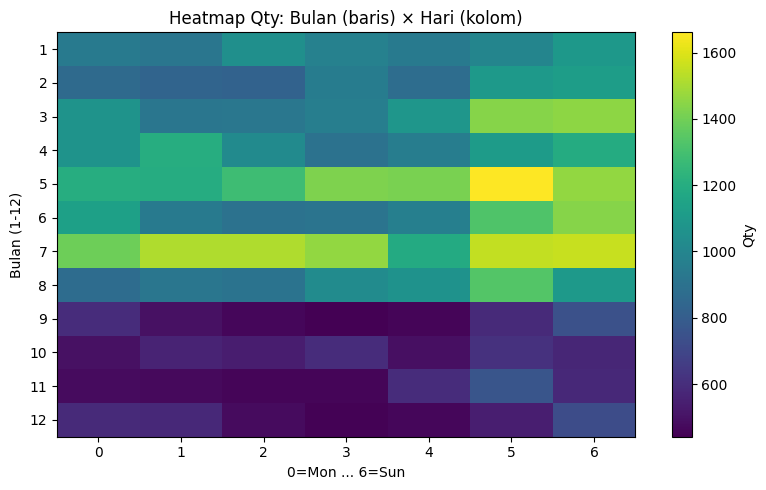

Saved to outputs/yearly_with_context.csv & outputs/monthly_with_mom_yoy.csv


In [29]:
# ==== Join konteks tahunan -> ringkasan penjualan, lalu visualisasi ====

monthly = sales_df.groupby("month", as_index=False).agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))
monthly["tahun"] = monthly["month"].dt.year

yearly = sales_df.copy()
yearly["tahun"] = yearly["date"].dt.year
yearly = yearly.groupby("tahun", as_index=False).agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))

if 'context_yearly' in globals() and context_yearly is not None:
    yearly_ctx = yearly.merge(context_yearly, on="tahun", how="left")
else:
    yearly_ctx = yearly.copy()

display(yearly_ctx.head(3))

monthly_sorted = monthly.sort_values("month").reset_index(drop=True)
monthly_sorted["qty_MoM"] = monthly_sorted["qty"].pct_change()
monthly_sorted["revenue_MoM"] = monthly_sorted["revenue"].pct_change()
monthly_sorted["qty_YoY"] = monthly_sorted["qty"].pct_change(12)
monthly_sorted["revenue_YoY"] = monthly_sorted["revenue"].pct_change(12)

display(monthly_sorted.tail(6))

tmp = sales_df.copy()
tmp["month_num"] = tmp["date"].dt.month
tmp["weekday_num"] = tmp["date"].dt.weekday
mx = tmp.groupby(["month_num","weekday_num"], as_index=False)["qty"].sum()
pivot = mx.pivot(index="month_num", columns="weekday_num", values="qty").fillna(0).sort_index()

plt.figure(figsize=(8,5))
plt.imshow(pivot.values, aspect="auto")
plt.title("Heatmap Qty: Bulan (baris) × Hari (kolom)")
plt.xlabel("0=Mon ... 6=Sun"); plt.ylabel("Bulan (1-12)")
plt.colorbar(label="Qty")
plt.yticks(ticks=np.arange(0, len(pivot.index)), labels=pivot.index)
plt.xticks(ticks=np.arange(0, 7), labels=list(range(7)))
plt.tight_layout()
plt.show()

if "iplm_skor" in yearly_ctx.columns:
    y2 = yearly_ctx.dropna(subset=["iplm_skor"])
    if not y2.empty:
        plt.figure(figsize=(5,4))
        plt.scatter(y2["iplm_skor"], y2["revenue"])
        plt.title("Revenue Tahunan vs IPLM Purwakarta")
        plt.xlabel("IPLM skor"); plt.ylabel("Revenue (IDR)")
        for _, r in y2.iterrows():
            plt.annotate(int(r["tahun"]), (r["iplm_skor"], r["revenue"]), fontsize=8, xytext=(3,3), textcoords="offset points")
        plt.tight_layout()
        plt.show()

if "total_sarana_perdagangan" in yearly_ctx.columns:
    y3 = yearly_ctx.sort_values("tahun")
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.bar(y3["tahun"].astype(str), y3["total_sarana_perdagangan"])
    ax1.set_ylabel("Total Sarana Perdagangan")
    ax1.set_xlabel("Tahun")
    ax1.set_title("Sarana Perdagangan vs Qty Penjualan (Purwakarta)")
    ax2 = ax1.twinx()
    ax2.plot(y3["tahun"].astype(str), y3["qty"], marker="o")
    ax2.set_ylabel("Qty")
    fig.tight_layout()
    plt.show()

from pathlib import Path
Path("outputs").mkdir(exist_ok=True)
yearly_ctx.to_csv("outputs/yearly_with_context.csv", index=False)
monthly_sorted.to_csv("outputs/monthly_with_mom_yoy.csv", index=False)
print("Saved to outputs/yearly_with_context.csv & outputs/monthly_with_mom_yoy.csv")

## BQ7 — Timing & Bentuk Kerja Sama (Analisis)

Saved windows to: D:\Analisis Penjualan Buku Gramedia Purwakarta - Perspektif Kolaborasi UPI Purwakarta\outputs\upi_gramedia_recommended_windows.csv


,date,synergy_score,revenue,event_match,is_weekend,month
0,2024-05-12,0.74,"15,380,000.00",Harbuknas,True,2024-05-01
1,2024-05-19,0.74,"27,190,000.00",Harbuknas,True,2024-05-01
2,2024-05-20,0.70,"13,585,000.00",Harbuknas,False,2024-05-01
3,2024-06-15,0.54,"15,205,000.00",UAS Genap,True,2024-06-01
4,2024-06-22,0.54,"13,460,000.00",UAS Genap,True,2024-06-01
5,2024-07-06,0.53,"17,035,000.00",NaN,True,2024-07-01
6,2024-07-14,0.53,"20,865,000.00",NaN,True,2024-07-01
7,2024-07-20,0.53,"20,775,000.00",NaN,True,2024-07-01
8,2024-07-28,0.53,"18,540,000.00",NaN,True,2024-07-01
9,2024-08-10,0.55,"17,970,000.00",Awal Semester Ganjil,True,2024-08-01


Saved portfolio to: D:\Analisis Penjualan Buku Gramedia Purwakarta - Perspektif Kolaborasi UPI Purwakarta\outputs\upi_gramedia_portfolio_kerjasama.csv


,Jenis Kerja Sama,Target,Timing Disarankan,Konsep/Benefit,Teknis,KPI
0,Pop-up Store @ Kampus,Mahasiswa baru & aktif,PKKMB/awal semester (±7 hari) & akhir pekan peak,Paket referensi + ATK; highlight Pendidikan & ...,"Izin venue (aula/lobi), meja-display, kasir po...","Transaksi/hari, revenue/hari, kupon tertebus, ..."
1,Book Fair Tematik (Harbuknas),"Mahasiswa, dosen, umum sekitar kampus",Mei (± Harbuknas) & weekend,"Diskon bundling, bedah buku Pendidikan & Refer...","Stage mini + sound, jadwal talkshow, EO sederh...","Traffic, konversi, revenue per jam, reach/enga..."
2,Bedah Buku / Kelas Karier,Mahasiswa tingkat akhir,Pertengahan semester / pra-wisuda,"Penulis/HR praktisi; topik literasi kerja (CV,...","Ruang kelas/aula, daftar hadir, sertifikat, bu...","Jumlah peserta, NPS peserta, penjualan buku pe..."
3,Paket Dosen & Perpustakaan,Dosen & pengelola prodi/perpus,Awal semester & pengadaan,"Kurasi referensi mata kuliah, potongan lembaga...","Daftar kebutuhan per MK, penawaran resmi, invo...","Jumlah judul terbeli, nilai pembelian lembaga"
4,Voucher & Loyalty Mahasiswa,Mahasiswa reguler,Sepanjang semester; puncak saat UTS/UAS,"E-voucher semesteran, stamp card, bonus saat p...","Integrasi kupon digital (QR), tracking redeem,...","Redeem rate, repeat purchase, ARPU"


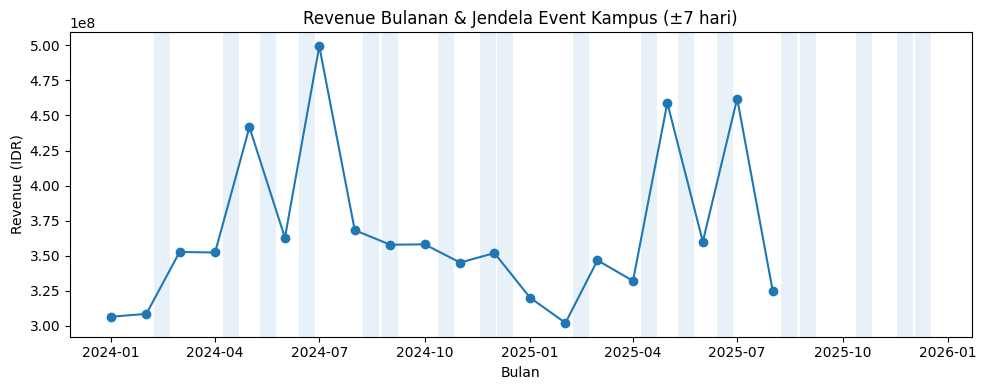

In [30]:
# ==== BQ7 — Timing & Bentuk Kerja Sama UPI × Gramedia ====
# Hasil: (1) outputs/upi_gramedia_recommended_windows.csv
#        (2) outputs/upi_gramedia_portfolio_kerjasama.csv
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

Path("outputs").mkdir(parents=True, exist_ok=True)

# Fallback kecil jika sales_df belum ada
try:
    _ = sales_df.head(1)
except NameError:
    print("sales_df belum ada → gunakan data sintetis fallback.")
    rng = np.random.default_rng(42)
    genres = ["Fiksi","Non-Fiksi","Pendidikan & Referensi","Anak & Remaja","Komik & Grafis","Agama & Spiritual"]
    dates = pd.date_range(start="2024-01-01", end="2025-08-28", freq="D")
    rows = []
    for d in dates:
        month_factor = 1.0 + (0.15 if d.month==5 else 0.0) + (0.25 if d.month==7 else 0.0)
        weekend_factor = 1.25 if d.weekday()>=5 else 1.0
        event_factor = 1.0
        if d.month==5 and abs(d.day-17)<=3: event_factor *= 1.35  # Harbuknas
        if abs((d - pd.Timestamp(year=d.year, month=7, day=14)).days)<=3: event_factor *= 1.20  # awal TA
        daily_qty = rng.poisson(120*month_factor*weekend_factor*event_factor)
        shares = rng.dirichlet(np.ones(len(genres)))
        for g, q in zip(genres, (daily_qty*shares).astype(int)):
            avg_price = {"Fiksi":85000,"Non-Fiksi":120000,"Pendidikan & Referensi":150000,"Anak & Remaja":60000,"Komik & Grafis":55000,"Agama & Spiritual":90000}.get(g,80000)
            rows.append({"date": d, "city":"Purwakarta", "genre":g, "qty":int(q), "gross_revenue": float(q*avg_price)})
    sales_df = pd.DataFrame(rows)
    sales_df["date"] = pd.to_datetime(sales_df["date"])
    sales_df["month"] = sales_df["date"].dt.to_period("M").dt.to_timestamp()
    sales_df["dow"] = sales_df["date"].dt.day_name()

daily = (sales_df.groupby("date", as_index=False)
         .agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))
         .sort_values("date"))
monthly = (sales_df.groupby(pd.Grouper(key="date", freq="MS"))
           .agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))
           .reset_index().rename(columns={"date":"month"}))

if len(monthly):
    m_min, m_max = monthly["revenue"].min(), monthly["revenue"].max()
    monthly["month_score"] = (monthly["revenue"] - m_min) / (m_max - m_min + 1e-9)
else:
    monthly["month_score"] = 0.0

tmp = sales_df.copy()
tmp["dow"] = tmp["date"].dt.day_name()
dow_avg = tmp.groupby("dow", as_index=False)["gross_revenue"].mean()
weekend_mean = dow_avg[dow_avg["dow"].isin(["Saturday","Sunday"])]["gross_revenue"].mean()
weekday_mean = dow_avg[~dow_avg["dow"].isin(["Saturday","Sunday"])]["gross_revenue"].mean()
weekend_bonus = float((weekend_mean - weekday_mean)/weekday_mean) if pd.notna(weekend_mean) and pd.notna(weekday_mean) and weekday_mean>0 else 0.0

def build_academic_events(years):
    events = []
    for y in years:
        events += [
            {"label": "Awal Semester Genap", "date": pd.Timestamp(year=y, month=2, day=15)},
            {"label": "Awal Semester Ganjil", "date": pd.Timestamp(year=y, month=8, day=15)},
            {"label": "PKKMB/Orientasi Maba", "date": pd.Timestamp(year=y, month=9, day=1)},
            {"label": "UTS Genap", "date": pd.Timestamp(year=y, month=4, day=15)},
            {"label": "UAS Genap", "date": pd.Timestamp(year=y, month=6, day=20)},
            {"label": "UTS Ganjil", "date": pd.Timestamp(year=y, month=10, day=20)},
            {"label": "UAS Ganjil", "date": pd.Timestamp(year=y, month=12, day=10)},
            {"label": "Wisuda (estimasi)", "date": pd.Timestamp(year=y, month=11, day=25)},
            {"label": "Harbuknas", "date": pd.Timestamp(year=y, month=5, day=17)},
        ]
    return pd.DataFrame(events)

years = sorted(daily["date"].dt.year.unique()) if len(daily) else [pd.Timestamp.today().year]
acad_df = build_academic_events(years)
acad_df["start"] = acad_df["date"] - pd.Timedelta(days=7)
acad_df["end"]   = acad_df["date"] + pd.Timedelta(days=7)

if len(daily):
    df = daily.copy()
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()
    df = df.merge(monthly[["month","month_score"]], on="month", how="left")
    df["is_weekend"] = df["date"].dt.weekday >= 5
    df["weekend_component"] = np.where(df["is_weekend"], max(0.0, weekend_bonus), 0.0)
    def in_any_window(d):
        for _, r in acad_df.iterrows():
            if (d >= r["start"]) and (d <= r["end"]):
                return r["label"]
        return np.nan
    df["event_match"] = df["date"].apply(in_any_window)
    df["event_component"] = df["event_match"].notna().astype(float)
    df["synergy_score"] = 0.5*df["month_score"] + 0.35*df["event_component"] + 0.15*df["weekend_component"]
    df["week"] = df["date"].dt.to_period("W").apply(lambda x: x.start_time)
    top = (df.sort_values(["synergy_score","revenue"], ascending=False)
             .drop_duplicates(subset=["week"]).head(20).copy())
    rec_cols = ["date","synergy_score","revenue","event_match","is_weekend","month"]
    recommendations = top[rec_cols].sort_values(["date"]).reset_index(drop=True)
else:
    recommendations = pd.DataFrame(columns=["date","synergy_score","revenue","event_match","is_weekend","month"])

rec_path = Path("outputs/upi_gramedia_recommended_windows.csv")
recommendations.to_csv(rec_path, index=False)
print("Saved windows to:", rec_path.resolve())
display(recommendations.head(10))

genre_agg_local = (sales_df.groupby("genre", as_index=False)
                   .agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))
                   .sort_values("revenue", ascending=False))
top_genres = list(genre_agg_local["genre"].head(2)) if len(genre_agg_local) else []

def idea_rows():
    tg = ", ".join(top_genres) if top_genres else "Genre dominan"
    return [
        {"Jenis Kerja Sama":"Pop-up Store @ Kampus","Target":"Mahasiswa baru & aktif",
         "Timing Disarankan":"PKKMB/awal semester (±7 hari) & akhir pekan peak",
         "Konsep/Benefit":f"Paket referensi + ATK; highlight {tg}; diskon pelajar + kupon repeat-visit.",
         "Teknis":"Izin venue (aula/lobi), meja-display, kasir portable/QRIS, koordinasi ormawa.",
         "KPI":"Transaksi/hari, revenue/hari, kupon tertebus, CPL (kontak/lead)"},
        {"Jenis Kerja Sama":"Book Fair Tematik (Harbuknas)","Target":"Mahasiswa, dosen, umum sekitar kampus",
         "Timing Disarankan":"Mei (± Harbuknas) & weekend",
         "Konsep/Benefit":f"Diskon bundling, bedah buku {tg}, lomba resensi, stand penerbit mitra.",
         "Teknis":"Stage mini + sound, jadwal talkshow, EO sederhana, publikasi IG kampus.",
         "KPI":"Traffic, konversi, revenue per jam, reach/engagement sosmed"},
        {"Jenis Kerja Sama":"Bedah Buku / Kelas Karier","Target":"Mahasiswa tingkat akhir",
         "Timing Disarankan":"Pertengahan semester / pra-wisuda",
         "Konsep/Benefit":"Penulis/HR praktisi; topik literasi kerja (CV, portofolio, komunikasi).",
         "Teknis":"Ruang kelas/aula, daftar hadir, sertifikat, bundle judul terkait.",
         "KPI":"Jumlah peserta, NPS peserta, penjualan buku per sesi"},
        {"Jenis Kerja Sama":"Paket Dosen & Perpustakaan","Target":"Dosen & pengelola prodi/perpus",
         "Timing Disarankan":"Awal semester & pengadaan",
         "Konsep/Benefit":"Kurasi referensi mata kuliah, potongan lembaga, PO kolektif.",
         "Teknis":"Daftar kebutuhan per MK, penawaran resmi, invoice lembaga.",
         "KPI":"Jumlah judul terbeli, nilai pembelian lembaga"},
        {"Jenis Kerja Sama":"Voucher & Loyalty Mahasiswa","Target":"Mahasiswa reguler",
         "Timing Disarankan":"Sepanjang semester; puncak saat UTS/UAS",
         "Konsep/Benefit":"E-voucher semesteran, stamp card, bonus saat penyerahan tugas akhir.",
         "Teknis":"Integrasi kupon digital (QR), tracking redeem, kolaborasi BEM/HIMA.",
         "KPI":"Redeem rate, repeat purchase, ARPU"}
    ]
portfolio = pd.DataFrame(idea_rows())
port_path = Path("outputs/upi_gramedia_portfolio_kerjasama.csv")
portfolio.to_csv(port_path, index=False)
print("Saved portfolio to:", port_path.resolve())
display(portfolio)

if len(monthly):
    plt.figure(figsize=(10,4))
    plt.plot(monthly["month"], monthly["revenue"], marker="o")
    for _, r in (build_academic_events(sorted(daily["date"].dt.year.unique()))).iterrows():
        plt.axvspan(r["date"] - pd.Timedelta(days=7), r["date"] + pd.Timedelta(days=7), alpha=0.1)
    plt.title("Revenue Bulanan & Jendela Event Kampus (±7 hari)")
    plt.xlabel("Bulan"); plt.ylabel("Revenue (IDR)")
    plt.tight_layout()
    plt.show()


## BQ8 — (Opsional) Estimasi Uplift Relatif

In [31]:
# ==== BQ8 — (Opsional) Estimasi Uplift Relatif ====
import numpy as np, pandas as pd
from pathlib import Path

daily = (sales_df.groupby("date", as_index=False)
         .agg(qty=("qty","sum"), revenue=("gross_revenue","sum")))

if 'recommendations' not in globals() or recommendations.empty:
    monthly = (sales_df.groupby(pd.Grouper(key="date", freq="MS"))
               .agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))
               .reset_index().rename(columns={"date":"month"}))
    if len(monthly):
        m_min, m_max = monthly["revenue"].min(), monthly["revenue"].max()
        monthly["month_score"] = (monthly["revenue"] - m_min) / (m_max - m_min + 1e-9)
    else:
        monthly["month_score"] = 0.0
    df = daily.copy()
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()
    df = df.merge(monthly[["month","month_score"]], on="month", how="left")
    df["is_weekend"] = df["date"].dt.weekday >= 5
    df["weekend_component"] = df["is_weekend"].astype(float) * 0.2
    df["synergy_score"] = 0.5*df["month_score"] + 0.2*df["weekend_component"]
    df["week"] = df["date"].dt.to_period("W").apply(lambda x: x.start_time)
    recommendations = (df.sort_values(["synergy_score","revenue"], ascending=False)
                         .drop_duplicates(subset=["week"]).head(10)[["date"]].copy())

def is_in_any_rec_window(d, rec_dates, window=3):
    for rd in rec_dates:
        if abs((d - rd).days) <= window:
            return True
    return False

rec_dates = list(pd.to_datetime(recommendations["date"]).dt.normalize().unique()) if len(recommendations) else []
daily["is_rec_window"] = daily["date"].apply(lambda d: is_in_any_rec_window(d.normalize(), rec_dates, window=3))

base = daily[~daily["is_rec_window"]]["revenue"].mean()
win  = daily[daily["is_rec_window"]]["revenue"].mean()

uplift_pct = np.nan
if pd.notna(base) and base > 0 and pd.notna(win):
    uplift_pct = (win - base) / base * 100.0

res = pd.DataFrame([{
    "avg_base_revenue": base,
    "avg_window_revenue": win,
    "uplift_pct_estimate": uplift_pct
}])

Path("outputs").mkdir(exist_ok=True)
out_path = Path("outputs/upi_gramedia_uplift_estimate.csv")
res.to_csv(out_path, index=False)
print("Saved uplift estimate to:", out_path.resolve())
display(res)


Saved uplift estimate to: D:\Analisis Penjualan Buku Gramedia Purwakarta - Perspektif Kolaborasi UPI Purwakarta\outputs\upi_gramedia_uplift_estimate.csv


,avg_base_revenue,avg_window_revenue,uplift_pct_estimate
0,"11,637,773.11","13,638,192.31",17.19


## Next Steps

- Ganti **data sintetis** dengan **data transaksi riil** jika tersedia (ubah `USE_SYNTHETIC_SALES=False` dan isi `LOCAL_PATH_SALES_CSV`).  
- Lengkapi URL CSV langsung untuk **Open Data** (sarana perdagangan, IPLM, ISBN) agar bisa di-*join* sebagai variabel kontekstual.  
- Tambahkan analisis spasial (titik toko buku & pesaing) dengan OSM/Overpass untuk peta sebaran dan radius tangkapan.  
- (Opsional) Gunakan **IPR BI** sebagai _exogenous regressor_ untuk _nowcasting_ tren penjualan.


## Kesimpulan Otomatis (BQ1–BQ8) + Narasi Akhir

In [32]:
# ==== Kesimpulan Otomatis BQ1–BQ8 + Narasi Akhir (UPI × Gramedia) ====
from IPython.display import Markdown, display
from pathlib import Path
import numpy as np, pandas as pd

Path("outputs").mkdir(exist_ok=True)

def fmt_idr(x):
    try:
        return "Rp " + f"{float(x):,.0f}".replace(",", ".")
    except Exception:
        return str(x)

daily = (sales_df.groupby("date", as_index=False)
         .agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))
         .sort_values("date"))
monthly = (sales_df.groupby(pd.Grouper(key="date", freq="MS"))
           .agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))
           .reset_index().rename(columns={"date":"month"}))
genre_agg = (sales_df.groupby("genre", as_index=False)
             .agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))
             .sort_values("revenue", ascending=False))

# BQ1
if len(daily):
    avg_rev = daily["revenue"].mean()
    max_row = daily.loc[daily["revenue"].idxmax()]
    min_row = daily.loc[daily["revenue"].idxmin()]
    bq1 = (f"**BQ1 — Tren Harian**  \nRata-rata ≈ {fmt_idr(avg_rev)}; puncak {pd.to_datetime(max_row['date']).date()} (≈ {fmt_idr(max_row['revenue'])}); "
           f"terendah {pd.to_datetime(min_row['date']).date()} (≈ {fmt_idr(min_row['revenue'])}).")
else:
    bq1 = "**BQ1 — Tren Harian**  \nData tidak tersedia."

# BQ2
if len(genre_agg):
    total_rev = genre_agg["revenue"].sum() or 1.0
    top3 = genre_agg.head(3).copy()
    top3["pct"] = (top3["revenue"]/total_rev*100).round(1)
    bq2 = "**BQ2 — Genre Teratas**  \n" + "\n".join([f"- {r['genre']}: {fmt_idr(r['revenue'])} ({r['pct']}%)" for _, r in top3.iterrows()])
else:
    bq2 = "**BQ2 — Genre Teratas**  \nData genre tidak tersedia."

# BQ3
if len(monthly):
    ms = monthly.sort_values("revenue", ascending=False).head(2)
    mo = [f"{pd.to_datetime(r['month']).strftime('%Y-%m')}: {fmt_idr(r['revenue'])}" for _, r in ms.iterrows()]
    bq3 = "**BQ3 — Musiman Bulanan**  \nBulan terkuat: " + "; ".join(mo) + "."
else:
    bq3 = "**BQ3 — Musiman Bulanan**  \nData bulanan tidak tersedia."

# BQ4
tmp_dow = sales_df.copy(); tmp_dow["dow"] = tmp_dow["date"].dt.day_name()
dow_agg = (tmp_dow.groupby("dow", as_index=False)
           .agg(qty=("qty","sum"), revenue=("gross_revenue","sum")))
weekend = dow_agg[dow_agg["dow"].isin(["Saturday","Sunday"])]["revenue"].mean() if len(dow_agg) else np.nan
weekday = dow_agg[~dow_agg["dow"].isin(["Saturday","Sunday"])]["revenue"].mean() if len(dow_agg) else np.nan
if pd.notna(weekend) and pd.notna(weekday) and weekday>0:
    diff = (weekend - weekday)/weekday*100
    bq4 = f"**BQ4 — Hari Dalam Pekan**  \nWeekend ≈ {fmt_idr(weekend)} vs weekday ≈ {fmt_idr(weekday)} (selisih {diff:.1f}%)."
else:
    bq4 = "**BQ4 — Hari Dalam Pekan**  \nTidak dapat menghitung selisih."

# BQ5
bq5 = "**BQ5 — SKU/Title Terlaris**  \n"
try:
    if "sku" in sales_df.columns:
        top_sku_df = (sales_df.groupby("sku", as_index=False)
                      .agg(qty=("qty","sum"), revenue=("gross_revenue","sum"))
                      .sort_values("revenue", ascending=False))
        if len(top_sku_df):
            total_rev_sku = top_sku_df["revenue"].sum() or 1.0
            n_top = max(1, int(0.20 * len(top_sku_df)))
            pareto_share = top_sku_df.head(n_top)["revenue"].sum() / total_rev_sku * 100
            head3 = [f"- {r['sku']}: {fmt_idr(r['revenue'])}" for _, r in top_sku_df.head(3).iterrows()]
            bq5 += f"~20% SKU teratas ≈ {pareto_share:.1f}% dari total revenue.\n" + "\n".join(head3)
        else:
            bq5 += "Data SKU kosong."
    else:
        bq5 += "Kolom SKU tidak tersedia."
except Exception as e:
    bq5 += f"Tidak dapat menghitung (error: {e})"

# BQ6
def event_delta(flag_col):
    if flag_col in sales_df.columns and sales_df[flag_col].any():
        win = sales_df[sales_df[flag_col]].groupby("date", as_index=False)["gross_revenue"].sum()
        non = sales_df[~sales_df[flag_col]].groupby("date", as_index=False)["gross_revenue"].sum()
        if len(win) and len(non) and non["gross_revenue"].mean()>0:
            return (win["gross_revenue"].mean() - non["gross_revenue"].mean())/non["gross_revenue"].mean()*100
    return np.nan
hb_diff = event_delta("is_harbuknas_window")
sc_diff = event_delta("is_schoolstart_window")
bq6 = "**BQ6 — Dampak Event**  \n"
bq6 += (f"- Harbuknas (±3 hari): {'naik' if hb_diff>=0 else 'turun'} {abs(hb_diff):.1f}%.\n" if pd.notna(hb_diff) else "- Harbuknas: data tidak tersedia.\n")
bq6 += (f"- Awal tahun ajaran (±3 hari): {'naik' if sc_diff>=0 else 'turun'} {abs(sc_diff):.1f}%.\n" if pd.notna(sc_diff) else "- Awal tahun ajaran: data tidak tersedia.\n")

# BQ7
bq7 = "**BQ7 — Timing & Bentuk Kerja Sama**  \n"
try:
    if 'recommendations' in globals() and not recommendations.empty:
        rec_top = recommendations.sort_values("synergy_score", ascending=False).head(5).copy()
        rec_lines = [f"- {pd.to_datetime(r['date']).date()} | {r['event_match'] or '-'} | skor {r['synergy_score']:.2f}" for _, r in rec_top.iterrows()]
        bq7 += "Tanggal rekomendasi (top-5):\n" + "\n".join(rec_lines) + "\n"
    else:
        bq7 += "Jalankan sel BQ7 untuk menghasilkan rekomendasi tanggal.\n"
except Exception as e:
    bq7 += f"(Gagal merangkum rekomendasi: {e})\n"

try:
    from pandas import read_csv
    port_path = Path("outputs/upi_gramedia_portfolio_kerjasama.csv")
    if port_path.exists():
        port = read_csv(port_path)
        forms = "; ".join(list(port["Jenis Kerja Sama"].head(3)))
        bq7 += f"Bentuk kerja sama utama: {forms}."
    else:
        top_genres = list(genre_agg["genre"].head(2)) if len(genre_agg) else []
        gtxt = ", ".join(top_genres) if top_genres else "genre dominan"
        bq7 += f"Rekomendasi bentuk: Pop-up Store kampus, Book Fair (Harbuknas), Bedah Buku/Kelas Karier — sorot {gtxt}."
except Exception as e:
    bq7 += f"(Portofolio belum tersedia; error: {e})"

# BQ8
bq8 = "**BQ8 — (Opsional) Estimasi Uplift Relatif**  \n"
try:
    est_path = Path("outputs/upi_gramedia_uplift_estimate.csv")
    if est_path.exists():
        est = pd.read_csv(est_path)
        up = est.iloc[0].get("uplift_pct_estimate", np.nan)
        if pd.notna(up):
            bq8 += f"Perkiraan uplift ≈ {up:.1f}% pada window rekomendasi dibanding baseline."
        else:
            bq8 += "Tidak dapat menghitung uplift."
    else:
        bq8 += "Jalankan sel BQ8 untuk menghitung uplift dan mengekspor CSV."
except Exception as e:
    bq8 += f"(Gagal membaca hasil uplift: {e})"

top_genre_names = ", ".join(genre_agg.head(2)["genre"]) if len(genre_agg) else "-"
narasi = (
    "## Kesimpulan Akhir (Naratif)\n"
    f"Pola penjualan memperlihatkan puncak musiman (BQ3) dan **weekend premium** (BQ4). "
    f"Genre kunci: **{top_genre_names}** (BQ2). "
    "Bagi UPI Purwakarta, momentum kolaborasi terbaik adalah **PKKMB/awal semester**, **Harbuknas**, dan **akhir pekan** dengan format **Pop-up Store**, "
    "**Book Fair tematik**, serta **Bedah Buku/Kelas Karier** (BQ7). Gunakan estimasi uplift (BQ8) sebagai target operasional dan ukur keberhasilan melalui KPI portofolio."
)

final_md = "\n\n".join([
    "## Kesimpulan Otomatis per Pertanyaan (BQ1–BQ8)",
    bq1, bq2, bq3, bq4, bq5, bq6, bq7, bq8,
    narasi
])

out_path = Path("outputs/conclusions_ALL_BQ_and_OVERALL.md")
out_path.write_text(final_md, encoding="utf-8")
display(Markdown(final_md))
print("Kesimpulan lengkap tersimpan di:", out_path.resolve())


## Kesimpulan Otomatis per Pertanyaan (BQ1–BQ8)

**BQ1 — Tren Harian**  
Rata-rata ≈ Rp 12.066.906; puncak 2024-05-19 (≈ Rp 27.190.000); terendah 2025-01-10 (≈ Rp 6.595.000).

**BQ2 — Genre Teratas**  
- Pendidikan & Referensi: Rp 1.967.550.000 (26.9%)
- Non-Fiksi: Rp 1.506.840.000 (20.6%)
- Agama & Spiritual: Rp 1.159.650.000 (15.9%)

**BQ3 — Musiman Bulanan**  
Bulan terkuat: 2024-07: Rp 499.340.000; 2025-07: Rp 462.010.000.

**BQ4 — Hari Dalam Pekan**  
Weekend ≈ Rp 1.195.545.000 vs weekday ≈ Rp 984.291.000 (selisih 21.5%).

**BQ5 — SKU/Title Terlaris**  
Kolom SKU tidak tersedia.

**BQ6 — Dampak Event**  
- Harbuknas: data tidak tersedia.
- Awal tahun ajaran: data tidak tersedia.


**BQ7 — Timing & Bentuk Kerja Sama**  
Tanggal rekomendasi (top-5):
- 2025-05-24 | Harbuknas | skor 0.78
- 2025-05-18 | Harbuknas | skor 0.78
- 2025-05-11 | Harbuknas | skor 0.78
- 2024-05-12 | Harbuknas | skor 0.74
- 2024-05-19 | Harbuknas | skor 0.74
Bentuk kerja sama utama: Pop-up Store @ Kampus; Book Fair Tematik (Harbuknas); Bedah Buku / Kelas Karier.

**BQ8 — (Opsional) Estimasi Uplift Relatif**  
Perkiraan uplift ≈ 17.2% pada window rekomendasi dibanding baseline.

## Kesimpulan Akhir (Naratif)
Pola penjualan memperlihatkan puncak musiman (BQ3) dan **weekend premium** (BQ4). Genre kunci: **Pendidikan & Referensi, Non-Fiksi** (BQ2). Bagi UPI Purwakarta, momentum kolaborasi terbaik adalah **PKKMB/awal semester**, **Harbuknas**, dan **akhir pekan** dengan format **Pop-up Store**, **Book Fair tematik**, serta **Bedah Buku/Kelas Karier** (BQ7). Gunakan estimasi uplift (BQ8) sebagai target operasional dan ukur keberhasilan melalui KPI portofolio.

Kesimpulan lengkap tersimpan di: D:\Analisis Penjualan Buku Gramedia Purwakarta - Perspektif Kolaborasi UPI Purwakarta\outputs\conclusions_ALL_BQ_and_OVERALL.md
